# Continuous Variable Neural Net Simulation

This is largely based on https://github.com/XanaduAI/quantum-neural-networks/blob/master/function_fitting/function_fitting.py

First setting up the imports

In [1]:
import os
import time

import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rcParams

import tensorflow as tf

import strawberryfields as sf
from strawberryfields.ops import *

import sys
sys.path.append("..")
import version_check

/usr/local/lib/python3.5/dist-packages/scipy/__init__.py:144: UserWarning: Numpy 1.13.3 or above is required for this version of scipy (detected version 1.13.1)
  UserWarning)


Then set some hyperparameters from the simulation

In [2]:
# Fock basis truncation
cutoff = 10
# domain [-xmax, xmax] to perform the function fitting over
xmax = 1
# Number of batches to use in the optimization
# Each batch corresponds to a different input-output relation
batch_size = 50
# Number of photonic quantum layers
depth = 6

# variable clipping values
disp_clip = 1000
sq_clip = 50
kerr_clip = 50

# number of optimization steps
reps = 1000

# regularization
regularization = 0.0
reg_variance = 0.0

Loading the sine data from the initial experiment

In [3]:
train_data = np.load('sine_train_data.npy')
test_data = np.load('sine_test_data.npy')
data_y = np.load('sine_outputs.npy')

Randomly set the initial parameters

In [4]:
# Random initialization of gate parameters
sdev = 0.05

with tf.name_scope('variables'):
    d_r = tf.Variable(tf.random_normal(shape=[depth], stddev=sdev))
    d_phi = tf.Variable(tf.random_normal(shape=[depth], stddev=sdev))
    r1 = tf.Variable(tf.random_normal(shape=[depth], stddev=sdev))
    sq_r = tf.Variable(tf.random_normal(shape=[depth], stddev=sdev))
    sq_phi = tf.Variable(tf.random_normal(shape=[depth], stddev=sdev))
    r2 = tf.Variable(tf.random_normal(shape=[depth], stddev=sdev))
    kappa1 = tf.Variable(tf.random_normal(shape=[depth], stddev=sdev))

Set the engine up with a single qumode, then define a layer, a net, and start the engine

In [5]:
def prepare_engine(qumodes):
    global cost, loss, mean_x, errors_y, var, state_norm, input_data, output_data
    # construct the one-mode Strawberry Fields engine
    eng, q = sf.Engine(qumodes)

    def layer(i):
        """This function generates the ith layer of the quantum neural network.

        Note: it must be executed within a Strawberry Fields engine context.

        Args:
            i (int): the layer number.
        """
        with tf.name_scope('layer_{}'.format(i)):
            # displacement gate
            Dgate(tf.clip_by_value(d_r[i], -disp_clip, disp_clip), d_phi[i]) | q[0]
            # rotation gate
            Rgate(r1[i]) | q[0]
            # squeeze gate
            Sgate(tf.clip_by_value(sq_r[i], -sq_clip, sq_clip), sq_phi[i]) | q[0]
            # rotation gate
            Rgate(r2[i]) | q[0]
            # Kerr gate
            Kgate(tf.clip_by_value(kappa1[i], -kerr_clip, kerr_clip)) | q[0]

    # Use a TensorFlow placeholder to store the input data
    input_data = tf.placeholder(tf.float32, shape=[batch_size])

    # construct the circuit
    with eng:
        # the input data is encoded as displacement in the phase space
        Dgate(input_data) | q[0]

        for k in range(depth):
            # apply layers to the required depth
            layer(k)

    # run the engine
    state = eng.run('tf', cutoff_dim=cutoff, eval=False, batch_size=batch_size)

    # First, we calculate the x-quadrature expectation value
    ket = state.ket()
    mean_x, svd_x = state.quad_expectation(0)
    errors_y = tf.sqrt(svd_x)

    # the loss function is defined as mean(|<x>[batch_num] - data[batch_num]|^2)
    output_data = tf.placeholder(tf.float32, shape=[batch_size])
    loss = tf.reduce_mean(tf.abs(mean_x - output_data) ** 2)
    var = tf.reduce_mean(errors_y)

    # when constructing the cost function, we ensure that the norm of the state
    # remains close to 1, and that the variance in the error do not grow.
    state_norm = tf.abs(tf.reduce_mean(state.trace()))
    cost = loss + regularization * (tf.abs(state_norm - 1) ** 2) + reg_variance*var
    tf.summary.scalar('cost', cost)

In [6]:
def f3(x, eps=0.0):
    """The function f(x)=sin(pi*x)+noise"""
    return 1.0*(np.sin(1.0 * x * np.pi) + eps * np.random.normal(size=x.shape))

In [7]:
def visualize_state(session, source_function, save_state = False):
    predictions = session.run(mean_x, feed_dict={input_data: test_data})

    if save_state:
        np.save('sine_test_predictions', test_predictions)
        print("Elapsed time is {} seconds".format(np.round(end_time - start_time)))

    x = np.linspace(-xmax, xmax, 200)

    # set plotting options
    rcParams['font.family'] = 'serif'
    rcParams['font.sans-serif'] = ['Computer Modern Roman']

    # Turn interactive plotting off
    plt.ioff()
    fig, ax = plt.subplots(1,1)

    # plot the function to be fitted, in green
    ax.plot(x, f3(x), color='#3f9b0b', zorder=1, linewidth=2)

    # plot the training data, in red
    ax.scatter(train_data, data_y, color='#fb2943', marker='o', zorder=2, s=75)

    # plot the test predictions, in blue
    ax.scatter(test_data, predictions, color='#0165fc', marker='x', zorder=3, s=75)

    ax.set_xlabel('Input', fontsize=18)
    ax.set_ylabel('Output', fontsize=18)
    ax.tick_params(axis='both', which='minor', labelsize=16)
    
    plt.show()

Run the training loop

In [8]:
def run_training_loop():
    optimiser = tf.train.AdamOptimizer()
    min_op = optimiser.minimize(cost)

    session = tf.Session()
    session.run(tf.global_variables_initializer())

    loss_vals = []
    error_vals = []

    # start time
    start_time = time.time()

    for i in range(reps+1):

        loss_, predictions, errors, mean_error, ket_norm, _ = session.run(
            [loss, mean_x, errors_y, var, state_norm, min_op],
            feed_dict={input_data: train_data, output_data: data_y})

        loss_vals.append(loss_)
        error_vals.append(mean_error)

        if i % 100 == 0:
            print('Step: {} Loss: {}'.format(i, loss_))
            visualize_state(session, predictions)

    end_time = time.time()
    return end_time - start_time

Step: 0 Loss: 0.22016894817352295


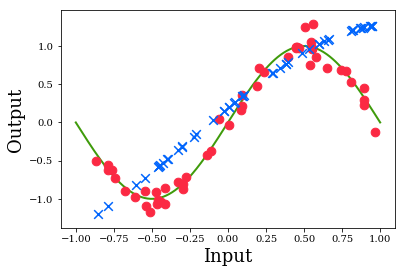

Step: 100 Loss: 0.045085787773132324


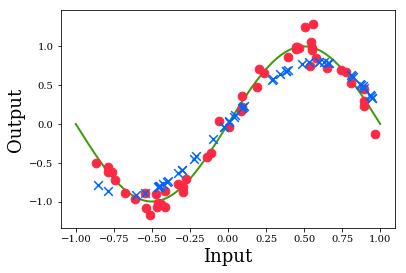

Step: 200 Loss: 0.023030631244182587


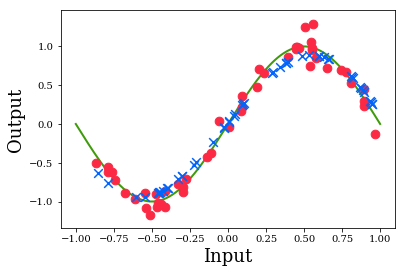

Step: 300 Loss: 0.014837712980806828


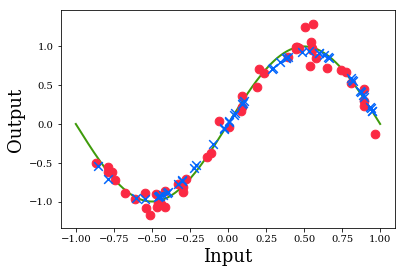

Step: 400 Loss: 0.011920452117919922


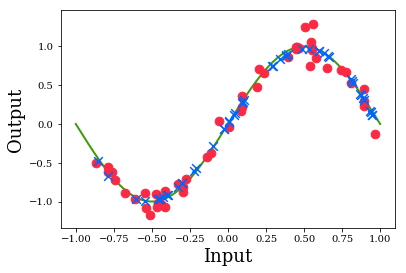

Step: 500 Loss: 0.011162434704601765


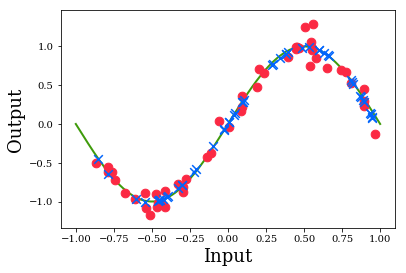

Step: 600 Loss: 0.01097511313855648


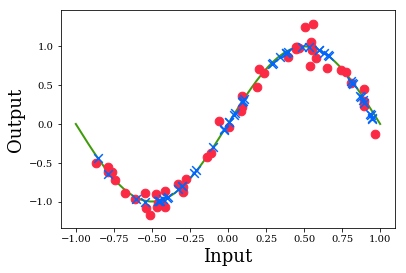

Step: 700 Loss: 0.010933821089565754


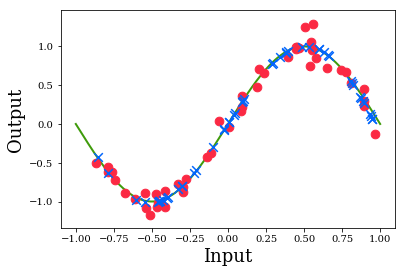

Step: 800 Loss: 0.01092570275068283


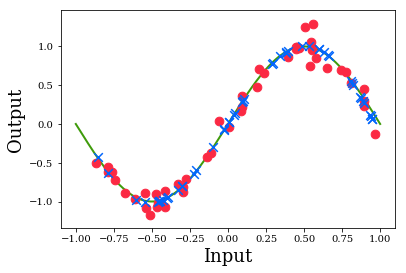

Step: 900 Loss: 0.010924065485596657


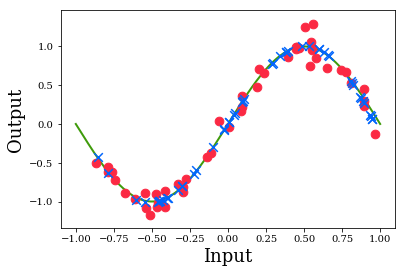

Step: 1000 Loss: 0.010923516005277634


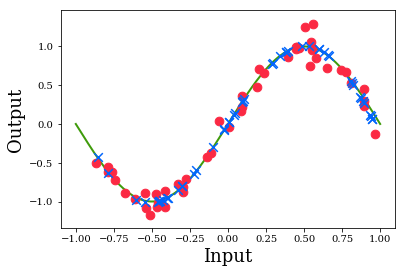

In [9]:
prepare_engine(1)
initial_time = run_training_loop()

In [10]:
print(initial_time)

296.94191694259644


In [ ]:
print("Elapsed time is {} seconds".format(np.round(initial_time)))